In [43]:
# from langchain_anthropic import ChatAnthropic
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langgraph.prebuilt import ToolNode

load_dotenv()


class AgentState(TypedDict):
    messages: Annotated[list, add_messages]


search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model_name="llama-3.1-8b-instant")

llm_with_tools = llm.bind_tools(tools=tools)


def model(state: AgentState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
    }


def tools_router(state: AgentState):
    last_message = state["messages"][-1]

    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tool_node"
    else:
        return "end"


tool_node = ToolNode(tools=tools)

graph = StateGraph(AgentState)

graph.add_node("model", model)
graph.add_node("tool_node", tool_node)
graph.set_entry_point("model")

graph.add_conditional_edges(
    "model", tools_router, {"tool_node": "tool_node", "end": END}
)
graph.add_edge("tool_node", "model")

app = graph.compile()

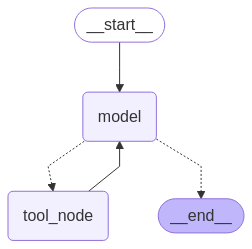

In [44]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [45]:
input = {"messages": ["What's the current weather in Meerut?"]}

events = app.stream(input=input, stream_mode="values")

for event in events:
    print(event)

{'messages': [HumanMessage(content="What's the current weather in Meerut?", additional_kwargs={}, response_metadata={}, id='8e648b49-4123-4565-8a0d-94526cacd705')]}
{'messages': [HumanMessage(content="What's the current weather in Meerut?", additional_kwargs={}, response_metadata={}, id='8e648b49-4123-4565-8a0d-94526cacd705'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bzwc', 'function': {'arguments': '{"query": "current weather in Meerut"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 573, 'total_tokens': 595, 'completion_time': 0.029333333, 'prompt_time': 0.056385058, 'queue_time': -0.084779538, 'total_time': 0.085718391}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-cb5584e3-f73c-42e7-b91b-e4942861b38a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '

In [46]:
input = {"messages": ["What's the current weather in Meerut?"]}

events = app.stream(input=input, stream_mode="updates")

for event in events:
    print(event)

{'model': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fr51', 'function': {'arguments': '{"query": "Meerut weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 287, 'total_tokens': 309, 'completion_time': 0.029333333, 'prompt_time': 0.018148681, 'queue_time': 0.163098345, 'total_time': 0.047482014}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6680b276-79b7-4a3b-ac3d-b56a7925dad8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Meerut weather today'}, 'id': 'call_fr51', 'type': 'tool_call'}], usage_metadata={'input_tokens': 287, 'output_tokens': 22, 'total_tokens': 309})]}}
{'tool_node': {'messages': [ToolMessage(content='[{"title": "Meerut Weather Forecast 28 Apr 2025 - Times of India", "url": "https://timesofindia.indiatimes.com/we

In [47]:
input = {"messages": ["Hi, How are you?"]}

events = app.astream_events(input=input, version="v2")

async for event in events:
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi, How are you?']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '496e6a65-9674-48b9-95c6-2f9d66b980be', 'metadata': {}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, How are you?', additional_kwargs={}, response_metadata={}, id='fd22e653-f83e-42e7-a6a4-bcb7e1bda9ad')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': '5a3d2d24-f6a9-45c6-a161-27db8c330025', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:3de707e1-409e-160b-da84-cded7dfb6876'}, 'parent_ids': ['496e6a65-9674-48b9-95c6-2f9d66b980be']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi, How are you?', additional_kwargs={}, response_metadata={}, id='fd22e653-f83e-42e7-a6a4-bcb7e1bda9ad')]]}}, 'name': 'ChatGroq', 'tags': ['seq:s

In [48]:
input = {"messages": ["Can you teel me about the history of meerut?"]}

events = app.astream_events(input=input, version="v2")

async for event in events:
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

The history of Meerut dates back to 322 BC, when it was a stronghold of the Mauryan Empire. It has also been associated with the Ashokan period, with Buddhist relics found close to the Jama Masjid. The city has undergone a transition from the ancient era of Mahabharata, and has been influenced by various cultures and empires throughout history.